In [131]:
import os
import numpy as np
import pandas as pd

from sklearn.impute import KNNImputer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_fscore_support

import seaborn as sn
import matplotlib.pyplot as plt

np.set_printoptions(precision=2)

In [151]:
__file__ = 'Routine Healthcare Screening - Covid Modelling.ipynb'
root_dir = os.path.abspath(os.path.join(__file__, "../"))
input_data_path = os.path.join(root_dir, 'data/AEH_Br_dataset_for_modelling.csv')

test_output_path = os.path.join(root_dir, 'test_predictions.csv')
train_output_path = os.path.join(root_dir, 'train_predictions.csv')

In [67]:
df = pd.read_csv(input_data_path)

In [35]:
df.isnull().sum()

% Fields available                                         0
Patient ID                                                 0
Patient age quantile                                       0
SARS-Cov-2 exam result                                     0
Patient addmited to regular ward (1=yes, 0=no)             0
Patient addmited to semi-intensive unit (1=yes, 0=no)      0
Patient addmited to intensive care unit (1=yes, 0=no)      0
Hematocrit                                                 0
Hemoglobin                                                 0
Platelets                                                  0
Lymphocytes                                                0
Basophils                                                  0
Eosinophils                                                0
Mean corpuscular volume (MCV)                              0
Monocytes                                                  1
Neutrophils                                               89
Urea                    

In [33]:
df.describe()

,% Fields available,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Lymphocytes,Basophils,Eosinophils,Mean corpuscular volume (MCV),Monocytes,Neutrophils,Urea,Creatinine,Potassium,Sodium
count,602.000000,602.000000,602.000000,602.000000,602.000000,602.000000,602.000000,602.000000,6.020000e+02,6.020000e+02,6.020000e+02,6.020000e+02,6.020000e+02,6.010000e+02,5.130000e+02,396.000000,423.000000,370.000000,368.000000
mean,87.975978,11.156146,0.137874,0.096346,0.069767,0.048173,-0.001267,-0.000900,-3.820598e-10,-7.863787e-09,-6.594685e-09,7.146180e-09,-4.149502e-09,-3.269551e-09,5.890838e-09,0.000922,0.004102,-0.001846,0.001172
std,13.806495,5.710620,0.345054,0.295310,0.254967,0.214309,1.001178,1.001418,1.000832e+00,1.000832e+00,1.000832e+00,1.000832e+00,1.000832e+00,1.000833e+00,1.000976e+00,1.002360,0.998793,1.002074,1.000792
min,61.538462,0.000000,0.000000,0.000000,0.000000,0.000000,-4.501420,-4.345603,-2.552426e+00,-1.865070e+00,-1.140144e+00,-8.355077e-01,-5.101581e+00,-2.163721e+00,-3.339775e+00,-1.630410,-2.389999,-2.283079,-5.246946
25%,69.230769,7.000000,0.000000,0.000000,0.000000,0.000000,-0.518807,-0.586244,-6.053457e-01,-7.307069e-01,-5.292256e-01,-6.669502e-01,-5.148128e-01,-6.141920e-01,-6.518655e-01,-0.588343,-0.632489,-0.800110,-0.575008
50%,92.307692,12.000000,0.000000,0.000000,0.000000,0.000000,0.053407,0.040316,-1.217160e-01,-1.426696e-02,-2.237665e-01,-3.298351e-01,6.604462e-02,-1.151911e-01,-5.364196e-02,-0.141742,-0.081113,-0.058626,0.143752
75%,100.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.717175,0.729532,5.314981e-01,5.976919e-01,3.871516e-01,3.443949e-01,6.268712e-01,4.888627e-01,6.838943e-01,0.453725,0.521954,0.682859,0.503132
max,100.000000,19.000000,1.000000,1.000000,1.000000,1.000000,2.662704,2.671868,9.532034e+00,3.764100e+00,1.107822e+01,8.350876e+00,3.410980e+00,4.533397e+00,2.535929e+00,11.246569,5.053572,3.401635,4.096930


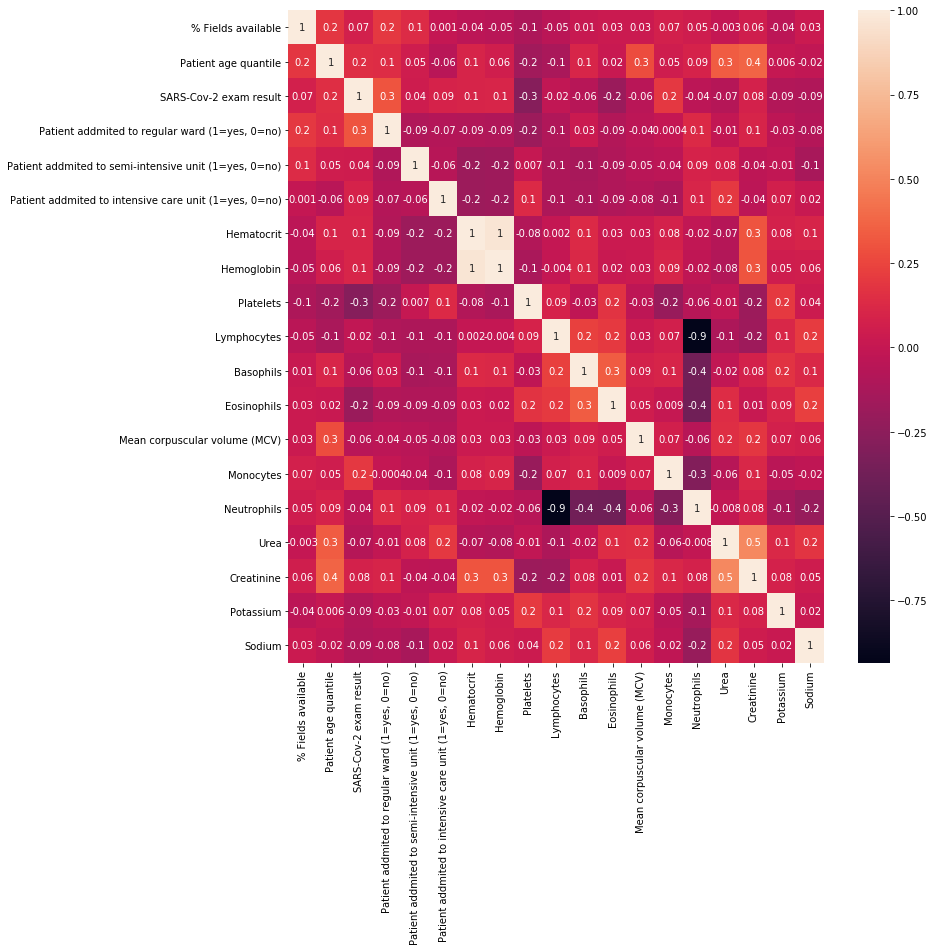

In [34]:
fig, ax = plt.subplots(figsize=(12,12))
sn.heatmap(ax=ax, data=df.corr(), annot=True, fmt='.1g')

## Impute Missing Values and Normalize

In [121]:
drop_columns = ['% Fields available','Patient ID','SARS-Cov-2 exam result',
             'Patient addmited to regular ward (1=yes, 0=no)',
             'Patient addmited to semi-intensive unit (1=yes, 0=no)',
             'Patient addmited to intensive care unit (1=yes, 0=no)']
df_temp = df.drop(columns=drop_columns)

imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
imputer.fit(df_temp)
df_imputed = imputer.transform(df_temp)

df_imputed = pd.DataFrame(df_imputed)
df_imputed = pd.concat([df[drop_columns]
                        , df_imputed]
                       , axis=1)
df_imputed.columns=drop_columns+list(df_temp.columns)

In [122]:
df_imputed.isnull().sum()

% Fields available                                       0
Patient ID                                               0
SARS-Cov-2 exam result                                   0
Patient addmited to regular ward (1=yes, 0=no)           0
Patient addmited to semi-intensive unit (1=yes, 0=no)    0
Patient addmited to intensive care unit (1=yes, 0=no)    0
Patient age quantile                                     0
Hematocrit                                               0
Hemoglobin                                               0
Platelets                                                0
Lymphocytes                                              0
Basophils                                                0
Eosinophils                                              0
Mean corpuscular volume (MCV)                            0
Monocytes                                                0
Neutrophils                                              0
Urea                                                    

In [123]:
df_imputed.describe()

,% Fields available,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Patient age quantile,Hematocrit,Hemoglobin,Platelets,Lymphocytes,Basophils,Eosinophils,Mean corpuscular volume (MCV),Monocytes,Neutrophils,Urea,Creatinine,Potassium,Sodium
count,602.000000,602.000000,602.000000,602.000000,602.000000,602.000000,602.000000,602.000000,6.020000e+02,6.020000e+02,6.020000e+02,6.020000e+02,6.020000e+02,602.000000,602.000000,602.000000,602.000000,602.000000,602.000000
mean,87.975978,0.137874,0.096346,0.069767,0.048173,11.156146,-0.001267,-0.000900,-3.820598e-10,-7.863787e-09,-6.594685e-09,7.146180e-09,-4.149502e-09,-0.000444,0.065535,-0.030463,-0.037241,0.005176,0.033073
std,13.806495,0.345054,0.295310,0.254967,0.214309,5.710620,1.001178,1.001418,1.000832e+00,1.000832e+00,1.000832e+00,1.000832e+00,1.000832e+00,1.000059,0.987286,0.837502,0.922309,0.833497,0.822682
min,61.538462,0.000000,0.000000,0.000000,0.000000,0.000000,-4.501420,-4.345603,-2.552426e+00,-1.865070e+00,-1.140144e+00,-8.355077e-01,-5.101581e+00,-2.163721,-3.339775,-1.630410,-2.389999,-2.283079,-5.246946
25%,69.230769,0.000000,0.000000,0.000000,0.000000,7.000000,-0.518807,-0.586244,-6.053457e-01,-7.307069e-01,-5.292256e-01,-6.669502e-01,-5.148128e-01,-0.614192,-0.626871,-0.450641,-0.568736,-0.552949,-0.287504
50%,92.307692,0.000000,0.000000,0.000000,0.000000,12.000000,0.053407,0.040316,-1.217160e-01,-1.426696e-02,-2.237665e-01,-3.298351e-01,6.604462e-02,-0.115191,0.035682,-0.141742,-0.081113,-0.058626,0.143752
75%,100.000000,0.000000,0.000000,0.000000,0.000000,16.000000,0.717175,0.729532,5.314981e-01,5.976919e-01,3.871516e-01,3.443949e-01,6.268712e-01,0.488863,0.776086,0.297415,0.435801,0.435697,0.503132
max,100.000000,1.000000,1.000000,1.000000,1.000000,19.000000,2.662704,2.671868,9.532034e+00,3.764100e+00,1.107822e+01,8.350876e+00,3.410980e+00,4.533397,2.535929,11.246569,5.053572,3.401635,4.096930


## Normalize data

In [124]:
df_temp = df_imputed.drop(columns=['% Fields available','Patient ID','SARS-Cov-2 exam result',
                                 'Patient addmited to regular ward (1=yes, 0=no)',
                                 'Patient addmited to semi-intensive unit (1=yes, 0=no)',
                                 'Patient addmited to intensive care unit (1=yes, 0=no)'])

df_imputed_norm = (df_temp - df_temp.min()) / (df_temp.max() - df_temp.min())

df_imputed_norm = pd.concat([df_imputed[['% Fields available','Patient ID','SARS-Cov-2 exam result',
                             'Patient addmited to regular ward (1=yes, 0=no)',
                             'Patient addmited to semi-intensive unit (1=yes, 0=no)',
                             'Patient addmited to intensive care unit (1=yes, 0=no)']]
                        , df_imputed_norm]
                       , axis=1)

In [125]:
df_imputed_norm.describe()

,% Fields available,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Patient age quantile,Hematocrit,Hemoglobin,Platelets,Lymphocytes,Basophils,Eosinophils,Mean corpuscular volume (MCV),Monocytes,Neutrophils,Urea,Creatinine,Potassium,Sodium
count,602.000000,602.000000,602.000000,602.000000,602.000000,602.000000,602.000000,602.000000,602.000000,602.000000,602.000000,602.000000,602.000000,602.000000,602.000000,602.000000,602.000000,602.000000,602.000000
mean,87.975978,0.137874,0.096346,0.069767,0.048173,0.587166,0.628151,0.619127,0.211216,0.331322,0.093314,0.090951,0.599300,0.323016,0.579558,0.124249,0.316079,0.402528,0.565078
std,13.806495,0.345054,0.295310,0.254967,0.214309,0.300559,0.139749,0.142704,0.082820,0.177794,0.081912,0.108947,0.117571,0.149327,0.168029,0.065039,0.123907,0.146621,0.088045
min,61.538462,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,69.230769,0.000000,0.000000,0.000000,0.000000,0.368421,0.555911,0.535714,0.161123,0.201515,0.050000,0.018349,0.538824,0.231373,0.461715,0.091618,0.244676,0.304348,0.530769
50%,92.307692,0.000000,0.000000,0.000000,0.000000,0.631579,0.635783,0.625000,0.201143,0.328788,0.075000,0.055046,0.607059,0.305882,0.574477,0.115607,0.310185,0.391304,0.576923
75%,100.000000,0.000000,0.000000,0.000000,0.000000,0.842105,0.728435,0.723214,0.255198,0.437500,0.125000,0.128440,0.672941,0.396078,0.700488,0.149711,0.379630,0.478261,0.615385
max,100.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Random Forest Classifier

In [126]:
labels = np.array(df_imputed_norm['SARS-Cov-2 exam result'])
features = df_imputed_norm.drop(['% Fields available','Patient ID','SARS-Cov-2 exam result'], axis = 1)
feature_list = list(features.columns)
features = np.array(features)

In [127]:
train_indices = []
test_indices = []

split_res = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=8)
for train_index, test_index in split_res.split(features, labels):
    train_indices.append(train_index)
    test_indices.append(test_index)
train_indices = train_indices[0]
test_indices = test_indices[0]

print('Training samples:',len(train_indices))
print('Positives in training sample:',labels[train_indices].sum())
print('Testing samples:',len(test_indices))
print('Positives in testing sample:',labels[test_indices].sum())

Training samples: 481
Positives in training sample: 66
Testing samples: 121
Positives in testing sample: 17


In [135]:
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')
model.fit(features[train_indices], labels[train_indices])
rf_predictions = model.predict(features[test_indices])

In [137]:
print('Accuracy:',accuracy_score(labels[test_indices],rf_predictions))
print('Precision and Recall:',precision_recall_fscore_support(np.array(labels[test_indices]),np.array(rf_predictions)))
print('ROC:',roc_auc_score(labels[test_indices],rf_predictions))

Accuracy: 0.8760330578512396
Precision and Recall: (array([0.88, 0.75]), array([0.99, 0.18]), array([0.93, 0.29]), array([104,  17], dtype=int64))
ROC: 0.5834276018099548


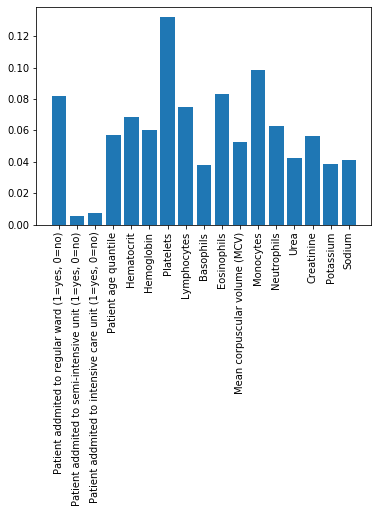

In [145]:
importance = model.feature_importances_
plt.bar([x for x in range(len(importance))], importance)
plt.xticks(ticks=range(len(feature_list)),labels=feature_list,rotation=90)
plt.show()

In [163]:
df_output = pd.concat([pd.DataFrame(df.loc[test_indices,feature_list].reset_index(drop=True))
                       ,pd.DataFrame(labels[test_indices])
                       ,pd.DataFrame(rf_predictions)], axis=1, ignore_index=True)
df_output.columns=feature_list+['SARS-Cov-2 exam result','Prediction']
df_output.to_csv(test_output_path)

rf_train_predictions = model.predict(features[train_indices])
df_train_output = pd.concat([pd.DataFrame(df.loc[train_indices,feature_list].reset_index(drop=True))
                       ,pd.DataFrame(labels[train_indices])
                       ,pd.DataFrame(rf_train_predictions)], axis=1, ignore_index=True)
df_train_output.columns=feature_list+['SARS-Cov-2 exam result','Prediction']
df_train_output.to_csv(train_output_path)

In [164]:
print('Accuracy:',accuracy_score(labels[train_indices],rf_train_predictions))
print('Precision and Recall:',precision_recall_fscore_support(np.array(labels[train_indices]),np.array(rf_train_predictions)))
print('ROC:',roc_auc_score(labels[train_indices],rf_train_predictions))

Accuracy: 1.0
Precision and Recall: (array([1., 1.]), array([1., 1.]), array([1., 1.]), array([415,  66], dtype=int64))
ROC: 1.0
